In [1]:
import py_ts_data
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import os
from kshape import _sbd as SBD
from auto_encoder import AutoEncoder, train_step
from utilities import min_max, normalize, augment_data, generateRandomPairs, calculatePreSBD

##### settings below
dataset = "UMD"
EPOCHS = 500
enable_data_augmentation = False
percentage_similarity_loss = 1
LSTM = True
##### settings above

X_train, y_train, X_test, y_test, info = py_ts_data.load_data(dataset, variables_as_channels=True)

print("Dataset shape: Train: {}, Test: {}".format(X_train.shape, X_test.shape))
print(np.shape(y_train))


if enable_data_augmentation or len(X_train) >= 1000:
    # LSTM will greatly extend the training time, so disable it if we have large data
    LSTM = False


##### don't change two lines below
title = "Dataset:{}-DA:{}-CoefSimilar:{}-LSTM:{}".format(dataset, enable_data_augmentation, percentage_similarity_loss, LSTM)
enable_same_noise = False

TS-Data path: /Users/wujiayang/Downloads/timeseries-similarity-master/data
Dataset shape: Train: (36, 150, 1), Test: (144, 150, 1)
(36,)


In [2]:
num_train = len(X_train)
if num_train < 1000 and enable_data_augmentation:
    X_train= augment_data(X_train, enable_same_noise = enable_same_noise)
    num_train = len(X_train)

# randomly generate N pairs:
num_of_pairs = num_train 
X, Y = generateRandomPairs(num_of_pairs, X_train)
# NlogN is too large, for N = 1000, NlogN would be 10K

normalized_X, normalized_Y, distance = calculatePreSBD(X, Y)


X shape:  (36, 150, 1)
Y shape:  (36, 150, 1)
distance shape:  (36,)


In [3]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# axs[0].plot(X_train[0])
# X_train = min_max(X_train, feature_range=(-1, 1))
# axs[1].plot(X_train[0])
# X_test = min_max(X_test, feature_range=(-1, 1))
# plt.show()

# Encode and Decode

In [4]:
kwargs = {
    "input_shape": (X_train.shape[1], X_train.shape[2]),
    "filters": [32, 64, 128],
    "kernel_sizes": [5, 5, 5],
    "code_size": 16,
}

ae = AutoEncoder(**kwargs)

# Training

In [5]:
loss_history = []
t1 = time.time()
for epoch in range(EPOCHS):
    #total_loss = train_step(X_train, ae)
    total_loss = train_step(normalized_X, normalized_Y, distance, ae, alpha = percentage_similarity_loss, LSTM = LSTM)
    loss_history.append(total_loss)
    print("Epoch {}: {}".format(epoch, total_loss), end="\r")
    
print("The training time is:", (time.time() - t1) / 60)


Epoch 359: [0.2156029]
rec_loss: tf.Tensor(0.17889962, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03624073], shape=(1,), dtype=float32)
Epoch 360: [0.21514034]
rec_loss: tf.Tensor(0.17859033, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03678244], shape=(1,), dtype=float32)
Epoch 361: [0.21537277]
rec_loss: tf.Tensor(0.17812899, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03624323], shape=(1,), dtype=float32)
Epoch 362: [0.21437222]
rec_loss: tf.Tensor(0.17834915, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03630169], shape=(1,), dtype=float32)
Epoch 363: [0.21465084]
rec_loss: tf.Tensor(0.17724577, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03660144], shape=(1,), dtype=float32)
Epoch 364: [0.2138472]
rec_loss: tf.Tensor(0.17701766, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03904194], shape=(1,), dtype=float32)
Epoch 365: [0.2160596]
rec_loss: tf.Tensor(0.17728004, shape=(), dtype=float32) simi_loss: tf.Tensor([0.03689463], shape=(1,), dtype=float32)
E

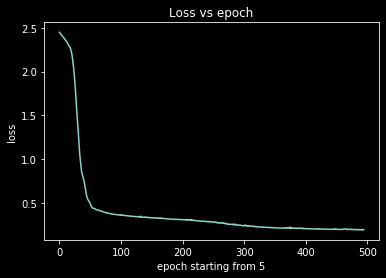

In [6]:
# plt.xlim(left = 5, right = len(loss_history))
plt.xlabel("epoch starting from 5")
plt.ylabel("loss")
plt.title("Loss vs epoch")
# print(loss_history[5:])
plt.plot(loss_history[5:])
# plt.show()
if not os.path.isdir("./images/" + dataset):
    os.mkdir("./images/" + dataset)

plt.savefig("./images/" + dataset + "/" + title + "-loss.png")


# Test

## Evaluate reconstruction

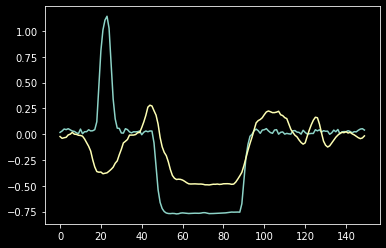

Mean L2 distance: 3.4989192485809326


In [7]:
code_test = ae.encode(X_test, LSTM = LSTM)
decoded_test = ae.decode(code_test)
plt.clf()
plt.plot(X_test[0], label = "Original TS")
plt.plot(decoded_test[0], label = "reconstructed TS")

plt.savefig("./images/" + dataset + "/" + title + "-reconstruction.png")
plt.show()

losses = []
for ground, predict in zip(X_test, decoded_test):
    losses.append(np.linalg.norm(ground - predict))

L2_distance = np.array(losses).mean()
print("Mean L2 distance: {}".format(L2_distance))

## Evaluate Similarity

In [8]:
from sklearn.neighbors import NearestNeighbors

nn_x_test = np.squeeze(X_test)
baseline_nn = NearestNeighbors(n_neighbors=10, metric=SBD).fit(nn_x_test)
code_nn = NearestNeighbors(n_neighbors=10).fit(code_test)# the default metric is euclidean distance

# For each item in the test data, find its 11 nearest neighbors in that dataset (the nn is itself)
baseline_11nn = baseline_nn.kneighbors(nn_x_test, 11, return_distance=False)
code_11nn     = code_nn.kneighbors(code_test, 11, return_distance=False)

# On average, how many common items are in the 10nn?
result = []
for b, c in zip(baseline_11nn, code_11nn):
    # remove the first nn (itself)
    b = set(b[1:])
    c = set(c[1:])
    result.append(len(b.intersection(c)))

ten_nn_score = np.array(result).mean()
print("10-nn score is:", ten_nn_score)
with open("./images/" + dataset + "/" + title + "-record.txt", "w") as f:
    f.write(" ".join([str(round(L2_distance,2)), str(round(ten_nn_score,2))]))


10-nn score is: 3.5208333333333335
